In [3]:
###########################
# Latent ODEs for Irregularly-Sampled Time Series
# Authors: Yulia Rubanova and Ricky Chen
###########################

import os
import numpy as np
import torch
from lib.utils import get_dict_template
import lib.utils as utils
from torchvision.datasets.utils import download_url
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

class WalkerPhysics(object):

	T = 200
	D = 18

	n_training_samples = 10000

	training_file = 'training.pt'

	def __init__(self, root, download = False, generate=True, device = torch.device("cpu")):
		self.root = root
		if download:
			self._download()

		if generate:
			self._generate_dataset()

		if not self._check_exists():
			raise RuntimeError('Dataset not found.' + ' You can use download=True to download it')

		data_file = os.path.join(self.data_folder, self.training_file)

		self.data = torch.Tensor(torch.load(data_file)).to(device)
		self.data, self.data_min, self.data_max = utils.normalize_data(self.data)

		self.device =device

	def visualize(self, traj, plot_name = 'traj', dirname='walker_imgs', video_name = None):
		r"""Generates images of the trajectory and stores them as <dirname>/traj<index>-<t>.jpg"""

		T, D = traj.size()

		traj = traj.cpu() * self.data_max.cpu() +  self.data_min.cpu()

		try:
			from dm_control import suite  # noqa: F401
		except ImportError as e:
			raise Exception('Deepmind Control Suite is required to visualize the dataset.') from e

		try:
			from PIL import Image  # noqa: F401
		except ImportError as e:
			raise Exception('PIL is required to visualize the dataset.') from e

		def save_image(data, filename):
			im = Image.fromarray(data)
			im.save(filename)

		os.makedirs(dirname, exist_ok=True)

		env = suite.load('walker', 'walk')
		physics = env.physics
		img = plt.imshow(physics.render(height=480, width=640, camera_id=0)) # Only call this once

		for t in range(T):
			with physics.reset_context():
				physics.data.qpos[:] = traj[t, :D // 2]
				physics.data.qvel[:] = traj[t, D // 2:]
			img.set_data(physics.render(height=480, width=640, camera_id=0))  # Just update the data
			plt.axis('off')
			ipythondisplay.display(plt.gcf())
			ipythondisplay.clear_output(wait=True)
			# save_image(
			# 	physics.render(height=480, width=640, camera_id=0),
			# 	os.path.join(dirname, plot_name + '-{:03d}.jpg'.format(t))
			# )

	def _generate_dataset(self):
		if self._check_exists():
			return
		os.makedirs(self.data_folder, exist_ok=True)
		print('Generating dataset...')
		train_data = self._generate_random_trajectories(self.n_training_samples)
		torch.save(train_data, os.path.join(self.data_folder, self.training_file))

	def _download(self):
		if self._check_exists():
			return

		print("Downloading the dataset [325MB] ...")
		os.makedirs(self.data_folder, exist_ok=True)
		url = "http://www.cs.toronto.edu/~rtqichen/datasets/HopperPhysics/training.pt"
		download_url(url, self.data_folder, "training.pt", None)

	def _generate_random_trajectories(self, n_samples):

		try:
			from dm_control import suite  # noqa: F401
		except ImportError as e:
			raise Exception('Deepmind Control Suite is required to generate the dataset.') from e

		env = suite.load('walker', 'walk')
		physics = env.physics

		# Store the state of the RNG to restore later.
		st0 = np.random.get_state()
		# np.random.seed(123)

		data = np.zeros((n_samples, self.T, self.D))
		for i in range(n_samples):
			with physics.reset_context():
				# Example initialization assuming the walker's root z position is included in qpos
				physics.data.qpos[2] = 0  # Set this to your calculated value
				physics.data.qpos[:2] = np.random.uniform(0, 0.5, size=2)  # x, y positions
				physics.data.qpos[3:] = np.random.uniform(-2, 2, size=physics.data.qpos[3:].shape)  # Other joint positions

			for t in range(self.T):
				data[i, t, :self.D // 2] = physics.data.qpos
				data[i, t, self.D // 2:] = physics.data.qvel
				physics.step()

		# Restore RNG.
		np.random.set_state(st0)
		return data

	def _check_exists(self):
		return os.path.exists(os.path.join(self.data_folder, self.training_file))

	@property
	def data_folder(self):
		return os.path.join(self.root, self.__class__.__name__)

	# def __getitem__(self, index):
	#     return self.data[index]

	def get_dataset(self):
		return self.data

	def __len__(self):
		return len(self.data)

	def size(self, ind = None):
		if ind is not None:
			return self.data.shape[ind]
		return self.data.shape
			
	def __repr__(self):
		fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
		fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
		fmt_str += '    Root Location: {}\n'.format(self.root)
		return fmt_str



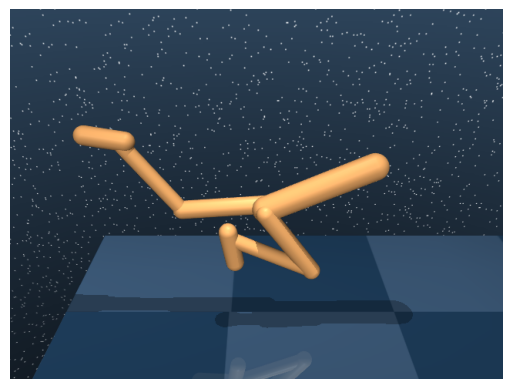

In [4]:
# from mujoco_physics import HopperPhysics
import torch
import os

output_dir = 'walker_imgs'
os.makedirs(output_dir, exist_ok=True)

#to get the frames saved for vizualization inside hopper_imgs
hopper = WalkerPhysics(root='data', download=False, generate=True)

dataset = hopper.get_dataset()
traj_index = 23   # Index of the trajectory you want to visualize
trajectory = dataset[traj_index]
hopper.visualize(trajectory, plot_name=f'traj_{traj_index}', dirname=output_dir)



## Random simulation

In [12]:
import numpy as np
from dm_control import suite
import matplotlib.pyplot as plt
import pandas as pd

# Load the environment
env = suite.load(domain_name="walker", task_name="walk")

# Random Policy Function
def random_policy(time_step):
    """ Returns random actions for the walker. """
    action_spec = env.action_spec()
    return np.random.uniform(low=action_spec.minimum, high=action_spec.maximum, size=action_spec.shape)

# Simple Policy Gradient (Placeholder for actual implementation)
def run_episode(env, policy, capture_images=False):
    """Runs a single episode and optionally captures images."""
    time_step = env.reset()
    cumulative_reward = 0
    images = []
    
    while not time_step.last():
        action = policy(time_step)
        time_step = env.step(action)
        cumulative_reward += time_step.reward
        
        if capture_images:
            # Render the environment and capture it as an image
            img = env.physics.render(camera_id=0, width=480, height=360)  # Specify the size as needed
            images.append(img)
    
    return cumulative_reward, images

def display_images(images):
    """Displays a sequence of images."""
    for img in images:
        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.axis('off')  # Turn off axis numbers and ticks
        plt.show()

def main(episodes=1):
    rewards = []
    for episode in range(episodes):
        reward, images = run_episode(env, random_policy, capture_images=False)
        rewards.append(reward)
        print(f"Episode {episode + 1}: Reward = {reward:.2f}")
        if images:  # If images were captured, display them
            display_images(images)

if __name__ == "__main__":
    main(1)  # Running one episode for demonstration


Episode 1: Reward = 28.66


## Interactive visualisation with obstacle

In [ ]:
from dm_control import suite
from dm_control import viewer
import numpy as np

env = suite.load(domain_name="walker", task_name="walk")
action_spec = env.action_spec()

# Define a uniform random policy.
def random_policy(time_step):
  del time_step  # Unused.
  return np.random.uniform(low=action_spec.minimum,
                           high=action_spec.maximum,
                           size=action_spec.shape)

# Launch the viewer application.
viewer.launch(env, policy=random_policy)

KeyboardInterrupt: 

In [ ]:
!pip install stable-baselines3 gym dm_control torch

## RL implementation

In [17]:
from dm_control import suite
from dm_control.rl.control import Environment
import numpy as np
from gym import spaces
from gym.envs.registration import register

# class DMCEnv(Environment):
#     def __init__(self, domain_name, task_name):
#         self.env = suite.load(domain_name=domain_name, task_name=task_name)
#         self.action_space = spaces.Box(low=self.env.action_spec().minimum, 
#                                        high=self.env.action_spec().maximum, 
#                                        dtype=np.float32)
#         obs_spec = self.env.observation_spec()
#         self.observation_space = spaces.Box(low=-np.inf, high=np.inf, 
#                                             shape=obs_spec['observations'].shape, 
#                                             dtype=np.float32)

#     def reset(self):
#         time_step = self.env.reset()
#         return time_step.observation['observations']

#     def step(self, action):
#         time_step = self.env.step(action)
#         reward = time_step.reward
#         done = time_step.last()
#         obs = time_step.observation['observations']
#         return obs, reward, done, {}


In [25]:
from gym import Env, spaces
import numpy as np
from gym import Env, spaces
import numpy as np

class DMCEnv(Env):
    def __init__(self, domain_name, task_name):
        super(DMCEnv, self).__init__()
        self.env = suite.load(domain_name=domain_name, task_name=task_name)
        self.action_space = spaces.Box(low=self.env.action_spec().minimum, 
                                       high=self.env.action_spec().maximum, 
                                       dtype=np.float32)

        # Get the observation space from the environment
        obs_spec = self.env.observation_spec()
        low, high = [], []
        for key, space in obs_spec.items():
            # Expand the scalar to a 1D array if necessary
            shape = space.shape if space.shape else (1,)
            low.append(np.full(shape, -np.inf))
            high.append(np.full(shape, np.inf))

        low = np.concatenate(low)
        high = np.concatenate(high)
        self.observation_space = spaces.Box(low=low, high=high, dtype=np.float32)

    def reset(self):
        time_step = self.env.reset()
        return self._get_obs(time_step)

    def step(self, action):
        time_step = self.env.step(action)
        obs = self._get_obs(time_step)
        reward = time_step.reward if time_step.reward is not None else 0
        done = time_step.last()
        return obs, reward, done, {}

    def _get_obs(self, time_step):
        # Concatenate all observation components into a single array
        obs = []
        for value in time_step.observation.values():
            # Ensure every component is a 1D array
            component = np.array(value, copy=False).flatten()
            obs.append(component)
        return np.concatenate(obs)


In [26]:
env = suite.load(domain_name="walker", task_name="walk")

In [27]:
env.observation_spec()

OrderedDict([('orientations',
              Array(shape=(14,), dtype=dtype('float64'), name='orientations')),
             ('height',
              Array(shape=(), dtype=dtype('float64'), name='height')),
             ('velocity',
              Array(shape=(9,), dtype=dtype('float64'), name='velocity'))])

In [29]:
!pip install shimmy

In [35]:
from stable_baselines3 import PPO

# Initialize the environment
env = DMCEnv(domain_name='walker', task_name='walk')

# Initialize the agent
model = PPO('MlpPolicy', env, verbose=1)

# Train the agent
# model.learn(total_timesteps=200000)

# Save the model
# model.save("walker_ppo_model")

# Optionally: Load the model
# model = PPO.load("walker_ppo_model")


Using cpu device



You appear to be missing MuJoCo.  We expected to find the file here: /Users/apekshagaonkar/.mujoco/mujoco210

This package only provides python bindings, the library must be installed separately.

Please follow the instructions on the README to install MuJoCo

    https://github.com/openai/mujoco-py#install-mujoco

Which can be downloaded from the website

    https://www.roboti.us/index.html



Exception: 
You appear to be missing MuJoCo.  We expected to find the file here: /Users/apekshagaonkar/.mujoco/mujoco210

This package only provides python bindings, the library must be installed separately.

Please follow the instructions on the README to install MuJoCo

    https://github.com/openai/mujoco-py#install-mujoco

Which can be downloaded from the website

    https://www.roboti.us/index.html


In [ ]:
obs = env.reset()
for _ in range(1000):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, info = env.step(action)
    env.render()  # If you want to visually inspect the performance
    if dones:
        obs = env.reset()
